In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose

In [2]:
%tensorflow_version 2.x
%matplotlib inline

## Load and Process the Dataset

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(X_train.shape, '\t', y_train.shape)
print(X_test.shape, '\t', y_test.shape)

(60000, 28, 28) 	 (60000,)
(10000, 28, 28) 	 (10000,)


The pixel values in the data lie between 0 and 255. So, we need to normalise them

In [5]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

Now, we use the .`reshape()` fucntion to reshape our data in the format expected by TensorFlow layer i.e., (no of samples, width, height, no of channels)

In [6]:
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

## Visualization of Samples
We plot a few random observations

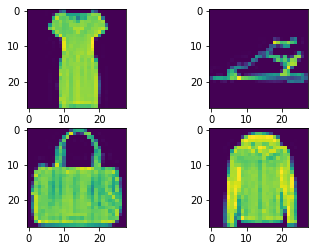

In [7]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[20][:,:,0])

plt.subplot(222)
plt.imshow(X_train[300][:,:,0])

plt.subplot(223)
plt.imshow(X_train[4000][:,:,0])

plt.subplot(224)
plt.imshow(X_train[5000][:,:,0])
plt.show()

## Model Architecture
We now design our VAE model; which involves of an encoder, the latent space and a decoder. Model implementation wise, the latent space can be considered to be a part of the encoder

### Encoder

In [8]:
enc_input = Input(shape=(28,28,1), name='encoder input')
x = Conv2D(128, 5, padding='same', activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

enc_shape = K.int_shape(x)

In [9]:
x = Flatten()(x)
x = Dense(32)(x)

#### Latent Space

In [10]:
latent_dim = 2 #2D space

z_mean = Dense(latent_dim, name='Z-mean')(x)
z_logvar = Dense(latent_dim, name='Z-logvariance')(x)

We need to define a function that takes in the mean and log variance parameters and return a random sample from the resulting distribution.

In [11]:
def sampling(args):
  mean, logvar = args
  eps = K.random_normal([latent_dim])
  rnd_sam = mean + K.exp(logvar/2) * eps
  return rnd_sam

By using a Lambda layer, we can thus define our latent space as shown below

In [12]:
z = Lambda(sampling, output_shape=latent_dim, name='latent-space')([z_mean, z_logvar])

In [13]:
encoder = keras.Model(enc_input, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 128)  3328        encoder input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   73792       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

### Decoder
Here, we need to take the randomly sampled 2D latent space vector and convert it back to the original format of the image i.e., 28x28 with a single channel

In [14]:
dec_input = Input(shape=(latent_dim,), name='decoder-input')

true_shape = enc_shape[1:]

y = Dense(np.prod(true_shape))(dec_input)
y = Reshape(target_shape=true_shape)(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
y = Conv2DTranspose(128, 5, padding='same', activation='relu')(y)
y = Conv2DTranspose(1, 5, padding='same', activation='relu')(y)

In [15]:
decoder = keras.Model(dec_input, y, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder-input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       2049

### Connecting all components,

In [16]:
enc_output = encoder(enc_input)
dec_output = decoder(enc_output)


vae = keras.Model(enc_input, dec_output, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 552548    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         356545    
Total params: 909,093
Trainable params: 909,093
Non-trainable params: 0
_________________________________________________________________


## Training
First, we need to define a custom loss function which trains our model based to improve an error defined as the sum of reconstruction loss and KL-Divergence loss.

In [17]:
def loss_func(z_mean, z_logvar):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(z_mean, z_logvar):
        kl_loss = -0.5 * K.sum(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

We can now compile and train

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))

In [19]:
history = vae.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/20
1875/1875 [==============================] - 30s 14ms/step - loss: 8.9757 - val_loss: 7.7460
Epoch 2/20
1875/1875 [==============================] - 26s 14ms/step - loss: 7.6706 - val_loss: 7.5855
Epoch 3/20
1875/1875 [==============================] - 26s 14ms/step - loss: 7.5426 - val_loss: 7.4972
Epoch 4/20
1875/1875 [==============================] - 26s 14ms/step - loss: 7.4569 - val_loss: 7.4151
Epoch 5/20
1875/1875 [==============================] - 26s 14ms/step - loss: 7.4017 - val_loss: 7.3659
Epoch 6/20
1875/1875 [==============================] - 26s 14ms/step - loss: 7.3505 - val_loss: 7.3130
Epoch 7/20
1875/1875 [==============================] - 26s 14ms/step - loss: 7.3076 - val_loss: 7.3036
Epoch 8/20
1875/1875 [==============================] - 26s 14ms/step - loss: 7.2701 - val_loss: 7.2596
Epoch 9/20
1875/1875 [==============================] - 26s 14ms/step - loss: 7.2378 - val_loss: 7.2224
Epoch 10/20
1875/1875 [==============================] - 26s 14m

Here, we performed naive hyperparameter tuning and achieved the above results. Whether the above loss is satisfactory or not depends on how well the model can reconstruct a given sample. This can only be gauged by visualising a few test observations.

## Visualization of Test samples

100


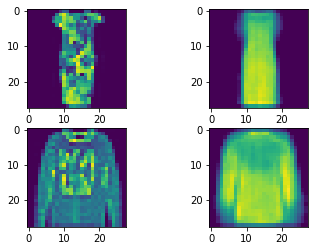

In [30]:
index = int(input())

y_pred = vae.predict(X_test)

plt.figure(1)
plt.subplot(221)
plt.imshow(X_test[index].reshape(28,28))

plt.subplot(222)
plt.imshow(y_pred[index].reshape(28,28))

plt.subplot(223)
plt.imshow(X_test[index*5].reshape(28,28))

plt.subplot(224)
plt.imshow(y_pred[index*5].reshape(28,28))
plt.show()

As seen above, the model is successful in reconstructing the general shape of the clothing item but finer details like text or patters are lost. For our case, this is satisfactory

## Downloading our models

In [31]:
keras.models.save_model(encoder, 'fm_encoder.h5')
keras.models.save_model(decoder, 'fm_decoder.h5')
keras.models.save_model(vae, 'fm_vae.h5')

## Exploring our Latent Space
The main application of a VAE is to obtain a low dimensional latent space for our data. Theoritically, every vector in this space is a reduced version of some sample in the original feature space. Exploring the latent space may therefore allow us to find weird, unique and interesting images that may be similar to training samples. The resulting visualization would look cooler with human face datasets, cat image datasets etc, but our plots get the point across.

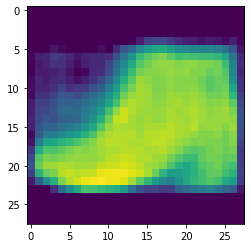

In [33]:
sample_vector = np.array([[3,7]])
decoded_example = decoder.predict(sample_vector)
plt.imshow(decoded_example.reshape(28,28))